# Markovs Chain Character Level

This project is associated with generating text using markov chain at character level.

Contents:

1. [Probabilistic Approach](#Probabilistic-Approach)
2. [Single Layer Neural Network](#Single-Layer-Neural-Network-Approach)
3. [3 Layer Neural Network](#Multi-Layer-Perceptron-Approach)
4. [Word Level Embeddings](#Word-Level-Embedding)

# Probabilistic Approach

In [1]:
import torch
import torch.nn.functional as F
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [72]:
text = open('input.txt', 'r').readlines()

In [3]:
len(text)

40000

In [4]:
X = [x for x in text]

In [5]:
chars = set(list(''.join(X)))
print(chars)

{'S', 'k', 'B', 'u', 'F', 'l', ' ', 'Y', 'b', 'p', 'c', '!', 'R', '$', 'o', 'w', 'G', "'", 'r', 'n', 'U', 't', 'X', 'A', 'K', 'W', 'N', 'g', 's', '\n', 'C', ':', '-', 'T', 'd', 'L', 'y', 'i', ';', 'V', '.', 'O', 'a', 'q', 'J', 'D', 'P', 'm', 'j', 'I', 'M', 'Q', 'z', 'v', 'H', 'h', 'f', 'e', '?', '3', '&', 'x', 'Z', 'E', ','}


In [6]:
num_chars = len(set(list(''.join(X))))
num_chars += 1 # for special token
num_chars

66

The text is cleaned. 

Now lets create character index and keep count.

In [7]:
counts = {}
for sample in X:
    s_ = list(sample)
    for ch1, ch2 in zip(s_, s_[1:]):
        bigram = (ch1, ch2)
        counts[bigram] = counts.get(bigram, 0)  + 1

In [8]:
sorted(counts.items(), key = lambda kv: -kv[1])[:5]

[(('e', ' '), 27643),
 ((' ', 't'), 23837),
 (('t', 'h'), 22739),
 (('h', 'e'), 18203),
 (('t', ' '), 16508)]

In [9]:
len(counts)

1351

We have 673 pairs of characters

In [10]:
N = torch.zeros((num_chars, num_chars), dtype=torch.int32)
N.shape

torch.Size([66, 66])

In [11]:
chars = sorted(chars)
print(chars)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [12]:
chtoi = {ch:i+1 for i, ch in enumerate(chars)}
chtoi['<c>'] = 0
itoch={i:ch for ch, i in chtoi.items()}

In [13]:
print(chtoi)

{'\n': 1, ' ': 2, '!': 3, '$': 4, '&': 5, "'": 6, ',': 7, '-': 8, '.': 9, '3': 10, ':': 11, ';': 12, '?': 13, 'A': 14, 'B': 15, 'C': 16, 'D': 17, 'E': 18, 'F': 19, 'G': 20, 'H': 21, 'I': 22, 'J': 23, 'K': 24, 'L': 25, 'M': 26, 'N': 27, 'O': 28, 'P': 29, 'Q': 30, 'R': 31, 'S': 32, 'T': 33, 'U': 34, 'V': 35, 'W': 36, 'X': 37, 'Y': 38, 'Z': 39, 'a': 40, 'b': 41, 'c': 42, 'd': 43, 'e': 44, 'f': 45, 'g': 46, 'h': 47, 'i': 48, 'j': 49, 'k': 50, 'l': 51, 'm': 52, 'n': 53, 'o': 54, 'p': 55, 'q': 56, 'r': 57, 's': 58, 't': 59, 'u': 60, 'v': 61, 'w': 62, 'x': 63, 'y': 64, 'z': 65, '<c>': 0}


In [14]:
print(itoch)

{1: '\n', 2: ' ', 3: '!', 4: '$', 5: '&', 6: "'", 7: ',', 8: '-', 9: '.', 10: '3', 11: ':', 12: ';', 13: '?', 14: 'A', 15: 'B', 16: 'C', 17: 'D', 18: 'E', 19: 'F', 20: 'G', 21: 'H', 22: 'I', 23: 'J', 24: 'K', 25: 'L', 26: 'M', 27: 'N', 28: 'O', 29: 'P', 30: 'Q', 31: 'R', 32: 'S', 33: 'T', 34: 'U', 35: 'V', 36: 'W', 37: 'X', 38: 'Y', 39: 'Z', 40: 'a', 41: 'b', 42: 'c', 43: 'd', 44: 'e', 45: 'f', 46: 'g', 47: 'h', 48: 'i', 49: 'j', 50: 'k', 51: 'l', 52: 'm', 53: 'n', 54: 'o', 55: 'p', 56: 'q', 57: 'r', 58: 's', 59: 't', 60: 'u', 61: 'v', 62: 'w', 63: 'x', 64: 'y', 65: 'z', 0: '<c>'}


In [15]:
for bigram, count in counts.items():
    ch1, ch2 = bigram
    idx1, idx2 = chtoi[ch1], chtoi[ch2]
    N[idx1, idx2] = count

In [16]:
N = N+1 # model smoothning
P = torch.zeros(N.shape)
for i in range(num_chars):
    p = N[i].float()
    p = p / p.sum()
    p = p.view(1, num_chars)
    P[i] = p

In [17]:
N.shape

torch.Size([66, 66])

In [18]:
P.sum().item()

66.0

In [19]:
g = torch.Generator()

In [20]:
seed_ = g.seed()
seed_

930312329494206641

In [21]:
g.manual_seed(seed_);

In [22]:
N.float().shape

torch.Size([66, 66])

In [23]:
P.float().shape

torch.Size([66, 66])

In [24]:
char_g = 500
idx = 0
gen_text = ''
for _ in range(char_g):
    p = N[idx].float()
    p = p / p.sum()
    idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    if itoch[idx] == '<d>':
        break
    gen_text += itoch[idx]
print(gen_text)

e patoned ntorercour lorfodgee anft wio f t prn a d we trne hicer lir I'm s mure t terefom h ofe
fanonl, bus prarve n; andst pe ang.
ia ll, wethes e y. muime; ice st beerars I bs,
aighte:
3?
juthe, H:
heerfid ceno be thulothe r.
XEdnsst lureange:
EXEThing ghefit CIVIn, getowafere:
DUSSoore, Thay cu tontherd iathincisare ve wn methant anoug t ps bery,
&ee. m'enno e.
sthe hend merir ne ay Comiur nes G kend todliens t be malded RWhavedlld is wocharmimy yse tatost t, veesooubay wathte!
JORURToyosere


In [25]:
print(f'Loss of the model: {-P.log().mean()}')

Loss of the model: 6.949477672576904


### Conclusion
The model works on just probablities and generates very bad text.

# Single Layer Neural Network Approach

In [26]:
# Trying on first 2 examples

xs = []
ys = []

for sample in X[:2]:
    s_ = list(sample)
    for ch1, ch2 in zip(s_, s_[1:]):
        ix1 = chtoi[ch1]
        ix2 = chtoi[ch2]

        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [27]:
print(f'{xs.shape=}')
print(f'{ys.shape=}')

xs.shape=torch.Size([59])
ys.shape=torch.Size([59])


In [28]:
W = torch.randn((num_chars, num_chars), generator=g, requires_grad=True) 

In [29]:
Xenc = F.one_hot(xs, num_classes=num_chars).float()
logits = Xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

In [30]:
probs.shape

torch.Size([59, 66])

In [31]:
loss = -probs[torch.arange(xs.shape[0]), ys].log().mean()
print('Loss of the network: ', loss.item())

Loss of the network:  4.698857307434082


In [32]:
W.grad = None
loss.backward()

In [33]:
W.data += -0.1 * W.grad

In [34]:
print(f'{W.shape=}')
print(f'{W.grad.shape=}')

W.shape=torch.Size([66, 66])
W.grad.shape=torch.Size([66, 66])


In [35]:
logits = Xenc @ W
F.cross_entropy(logits, ys)

tensor(4.6968, grad_fn=<NllLossBackward0>)

In [36]:
len(X)

40000

In [37]:
# creating training set

xs = []
ys = []

for sample in X:
    s_ = list(sample)
    for ch1, ch2 in zip(s_, s_[1:]):
        ix1 = chtoi[ch1]
        ix2 = chtoi[ch2]

        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f'{xs.shape=}')
print(f'{ys.shape=}')

xs.shape=torch.Size([1075394])
ys.shape=torch.Size([1075394])


In [38]:
# encoding X

Xenc = F.one_hot(xs, num_classes=num_chars).float()
print(f'{Xenc.shape=}')

Xenc.shape=torch.Size([1075394, 66])


In [39]:
# learning rate -> hyperparameter optimization

lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [40]:
epochs = 100_000
num_examples = xs.shape[0]
W = torch.randn((num_chars, num_chars), generator=g) * 0.1
W.requires_grad = True

lossi = []

In [41]:
# organizing the network

for k in range(epochs):
    ix = torch.randint(0, xs.shape[0], (32,)) # training on 32 examples
    Xenc_ = Xenc[ix]
    
    logits = Xenc_ @ W
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdims=True)
    # loss = -probs[torch.arange(num_examples), ys].log().mean()
    loss = F.cross_entropy(logits, ys[ix]) # this is a faster and better execution of the above 3 lines
    if k == 0:
        print(f'Loss: {loss.item()}')
    W.grad = None
    
    loss.backward()

    lr = 1 if k < epochs // 2 else 0.001
    W.data += -lr * W.grad

    lossi.append(loss.item())

print(f'Loss: {loss.item()}')

Loss: 4.185417175292969
Loss: 1.9669793844223022


In [42]:
-torch.tensor(1/28).log()

tensor(3.3322)

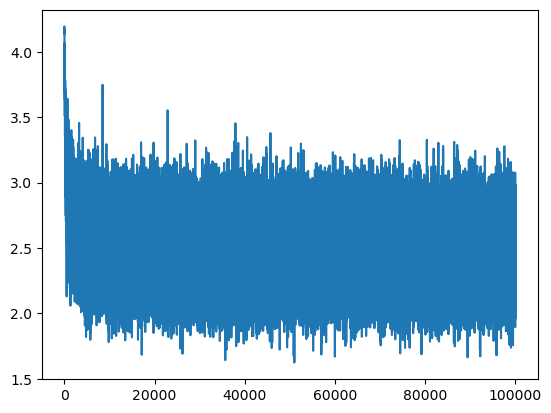

In [43]:
plt.plot(lossi);

In [44]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(16, 5))
# plt.xlabel('Learning Rate exponent')
# plt.ylabel('Loss')
# plt.title('Loss to LRE gragh')
# plt.plot(lri, lossi)
# plt.grid()
# plt.show()

In [45]:
logits.shape

torch.Size([32, 66])

In [46]:
# generating from the network trained

idx = 2
gen_text = ''
for _ in range(500):
    xenc = F.one_hot(torch.tensor([idx]), num_classes=num_chars).float()
    logits = xenc @ W
    counts = logits.exp()
    p = counts / counts.sum(1, keepdims = True)
    idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    if idx == 0:
        break
    gen_text += itoch[idx]
print(gen_text)

m toug,
chesh gil's crive, heaponde, I g, tiNGLA cothenelinoube, tewobeangg
CAn sted hono we the, r:
nomsthehe; ayour, whesumut oughe oriod ss dg nthirast sarind hayoa thend qu at, ce fa allsugere S:
guro st lenghas p ordJUCER:

Aysouray Jfom y ay atong'dous bes sathiny,
MERD: ffotoganold fouly
ABr EDWhithiftoran.
ff he acheleWhay ctexThal,
ishy:
quburis asharpreske' hea tokiay othangacirmarnd y.
?
f iedis ESiccthay,
ANoly y Iy l he.
quen,
We hy, irar Boung!
zeanthomart llmbe ncas ghedengest:
yo


### Conclusion:
The model gets trained on on data throught forward pass and backpropagation, eventually learning something and decreasing the loss.

We can see the model generated some meaningful words. But a lot of words that are generated are not meaningful. A lot of improvement has to be made.

# Multi-Layer Perceptron Approach

In [47]:
# taking context for a length of 3, can as per requirement


context_size = 3
xs, ys = [], []

for x in X[:2]:
    context = [0] * context_size
    
    for i, ch in enumerate(list(x)):
        ix = chtoi[ch]
        xs.append(context)
        ys.append(ix)
        
        print(''.join(itoch[j] for j in context), '-->', itoch[ix])

        context = context[1:] + [ix] # cropping and appending context

xs = torch.tensor(xs)
ys = torch.tensor(ys)

<c><c><c> --> F
<c><c>F --> i
<c>Fi --> r
Fir --> s
irs --> t
rst -->  
st  --> C
t C --> i
 Ci --> t
Cit --> i
iti --> z
tiz --> e
ize --> n
zen --> :
en: --> 

<c><c><c> --> B
<c><c>B --> e
<c>Be --> f
Bef --> o
efo --> r
for --> e
ore -->  
re  --> w
e w --> e
 we -->  
we  --> p
e p --> r
 pr --> o
pro --> c
roc --> e
oce --> e
cee --> d
eed -->  
ed  --> a
d a --> n
 an --> y
any -->  
ny  --> f
y f --> u
 fu --> r
fur --> t
urt --> h
rth --> e
the --> r
her --> ,
er, -->  
r,  --> h
, h --> e
 he --> a
hea --> r
ear -->  
ar  --> m
r m --> e
 me -->  
me  --> s
e s --> p
 sp --> e
spe --> a
pea --> k
eak --> .
ak. --> 



In [48]:
print(f'{xs.shape=}')
print(f'{ys.shape=}')

xs.shape=torch.Size([61, 3])
ys.shape=torch.Size([61])


In [49]:
xs[:10]

tensor([[ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 48],
        [19, 48, 57],
        [48, 57, 58],
        [57, 58, 59],
        [58, 59,  2],
        [59,  2, 16],
        [ 2, 16, 48],
        [16, 48, 59]])

In [50]:
ys[:10]

tensor([19, 48, 57, 58, 59,  2, 16, 48, 59, 48])

In [51]:
# a 3 layer nn consisting of:  a embedding layer, 2 hidden layers, and output layer

emb_dim = 2
C = torch.randn((num_chars, emb_dim))
W1 = torch.randn((context_size * emb_dim, 100)) 
b1 = torch.randn(100) 
W2 = torch.randn((W1.shape[1], num_chars)) 
b2 = torch.randn(num_chars)

In [52]:
# forward prop

h_pre = C[xs].view(-1, context_size * emb_dim)
h = torch.tanh(h_pre @ W1 + b1)
logits = h @ W2 + b2

In [53]:
# loss

loss = F.cross_entropy(logits, ys)
loss

tensor(16.1899)

In [54]:
chtoi = {ch:i+1 for i, ch in enumerate(chars)}
chtoi['<c>'] = 0
itoch={i:ch for ch, i in chtoi.items()}

In [55]:
#loading full dataset

context_size = 3
xs, ys = [], []

for x in X:
    context = [0] * context_size
    
    for i, ch in enumerate(list(x)):
        ix = chtoi[ch]
        xs.append(context)
        ys.append(ix)

        context = context[1:] + [ix] # cropping and appending context

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f'{xs.shape=}')
print(f'{ys.shape=}')

xs.shape=torch.Size([1115394, 3])
ys.shape=torch.Size([1115394])


In [56]:
# train, dev, test split

xs_train, xs_rest, ys_train, ys_rest = train_test_split(xs, ys, test_size = 0.2, random_state = 42)
xs_dev, xs_test, ys_dev, ys_test = train_test_split(xs_rest, ys_rest, test_size = 0.5, random_state = 42)


In [57]:
print(f'{xs_train.shape=}')
print(f'{xs_dev.shape=}')
print(f'{xs_test.shape=}')
print('---')
print(f'{ys_train.shape=}')
print(f'{ys_dev.shape=}')
print(f'{ys_test.shape=}')

xs_train.shape=torch.Size([892315, 3])
xs_dev.shape=torch.Size([111539, 3])
xs_test.shape=torch.Size([111540, 3])
---
ys_train.shape=torch.Size([892315])
ys_dev.shape=torch.Size([111539])
ys_test.shape=torch.Size([111540])


In [58]:
# organinizing the code

emb_dim = 5
n_hidden = 200

C = torch.randn((num_chars, emb_dim))
W1 = torch.randn((context_size * emb_dim, n_hidden)) * (5/3) / ((context_size * emb_dim) ** 0.5)
b1 = torch.randn(n_hidden) * 0.01 
W2 = torch.randn((n_hidden, num_chars)) * 0.1
b2 = torch.randn(num_chars) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [59]:
print(f'Parameters: {sum(p.nelement() for p in parameters)}')

Parameters: 16796


In [60]:
# learning rate -> hyperparameter optimization

lre = torch.linspace(-4, 0, 1000) # set this to no. of epochs
lrs = 10 ** lre
lri = []
lossi = []

In [61]:
epochs = 200000

for k in range(epochs):
    # forward
    ix = torch.randint(0, xs_train.shape[0], (32,))
    emb_ = C[xs_train[ix]].view(-1, context_size * emb_dim)
    h_pre = emb_ @ W1 + b1
    h = torch.tanh(h_pre)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ys[ix])
    # print(loss.item())
    if k == 0:
        print(f'{loss.item()=}')

    #backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[k]
    lr = 0.17 if k < epochs // 2 else 0.017
    #update
    for p in parameters:
        p.data += -lr * p.grad

    #stats
    # lri.append(lre[k % 1000])
    lossi.append(loss.item())
print(f'{loss.item()=}')

loss.item()=4.8314948081970215
loss.item()=2.8051888942718506


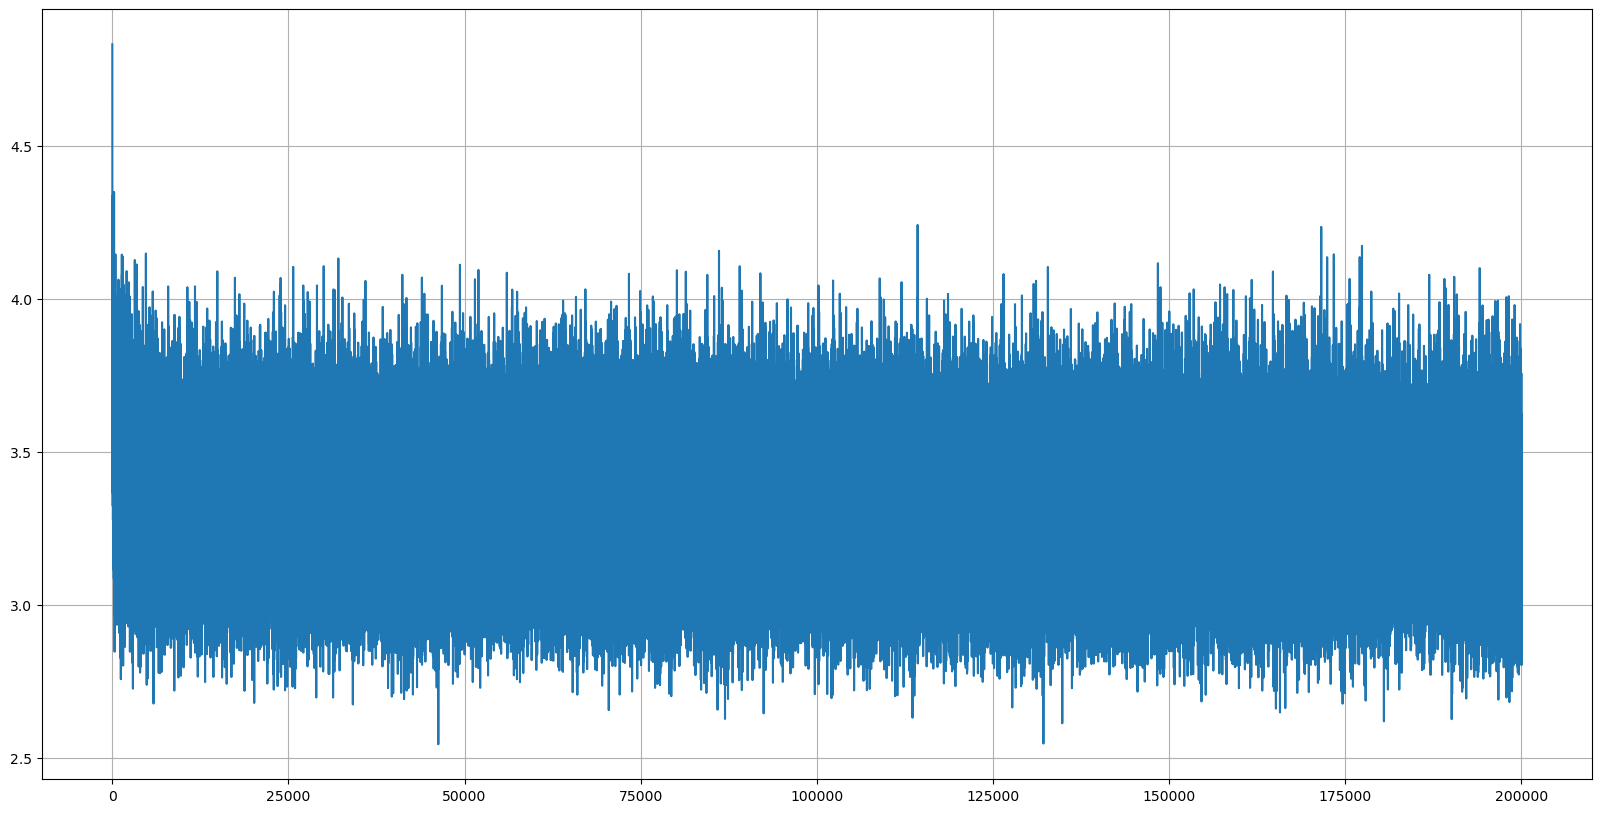

In [62]:
plt.figure(figsize=(20,10))
plt.grid('micro')
plt.plot(lossi);

In [63]:
# plt.plot(list(lri), list(lossi));
# to plot this, uncomment learning_rate code block along with the optimization marked code 

In [64]:
#dev loss

with torch.no_grad():
    emb = C[xs_dev].view(-1, context_size * emb_dim)
    h_pre = emb @ W1 + b1 
    h = torch.tanh(h_pre)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ys_dev)
    print('Loss: ',loss.item())

Loss:  3.312398672103882


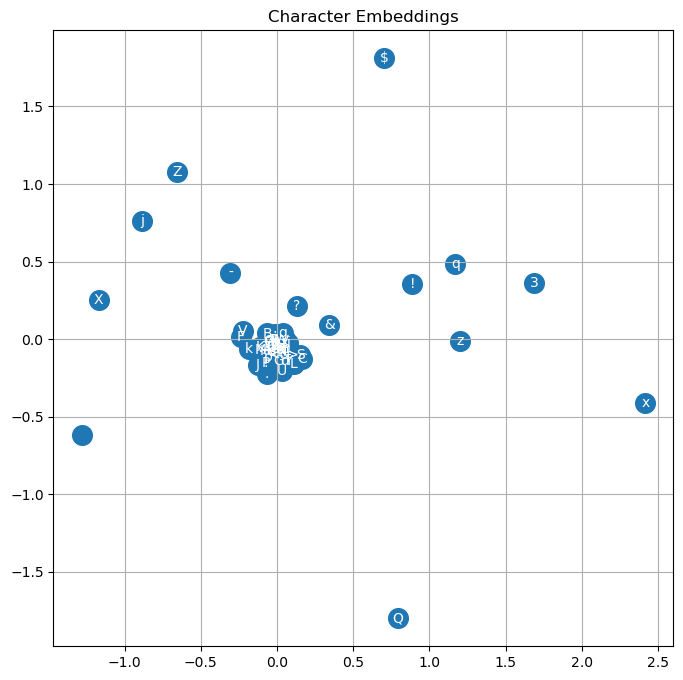

In [65]:
plt.figure(figsize=(8,8))
plt.title('Character Embeddings')
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itoch[i], ha='center', va='center', color='white')
plt.grid('micro');

In [66]:
# sampling from the model

output = []
word = 'IET'
context = [chtoi[ch] for ch in word]

for _ in range(500):
    emb = C[torch.tensor([context])].view(1, -1)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    output.append(ix)

print(word, ' ',''.join(itoch[i] for i in output))

IET   vsIreolu;ys aktsRmtsrfaWfdswrsa GOrkh:nu.ss hhl oeoeourtamoebtoserc eh
 m  s na
meeel
n
.EoeesHeftnp s
e ieeserOythlT
ha dg:Hwtas''iuebrlI, ulc l,stu rlaiutn sI f L daac tatun. ib 'o
p,
  iagu:mIo eS;h osb
nlAdyeastahofCp tMhom nsodc n LrMebemnrh ,ompa e syl yrRa  ug us l e.clOueo tgao tT
eef ef! dh rTrcOlihtls n
nsen
y esa?dt mulageey vo
toplt  lhvuIe.Iaaeoa
hp RIhOhweeeowuaNiAl s'i  eeeswhebeyaIfnlidyas .hfa rHs gole
Aywb h tou
dr oa
Il'rtsnm,oeDggRsl crJ bent wOapaefhylps , g;'obs ,TeacnooyB,


### Conclusion

Not a good network. Much more improvements need to be done.

# Word Level Embedding

In [193]:
d_text = ''.join(text)
print(j_text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [194]:
dialogs = d_text.split('\n\n')
dialogs[:10]

['First Citizen:\nBefore we proceed any further, hear me speak.',
 'All:\nSpeak, speak.',
 'First Citizen:\nYou are all resolved rather to die than to famish?',
 'All:\nResolved. resolved.',
 'First Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.',
 "All:\nWe know't, we know't.",
 "First Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?",
 "All:\nNo more talking on't; let it be done: away, away!",
 'Second Citizen:\nOne word, good citizens.',
 'First Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this 

In [195]:
for i, d in enumerate(dialogs):
    t = d.replace('\n', ' ')
    pattern = r"[^\w\s:]"
    t = re.sub(pattern, '', t)
    t = t
    dialogs[i] = t

In [196]:
d_ = ' '.join(dialogs)
word_corpus = set(d_.split())
word_corpus;

In [197]:
word_corpus = sorted(word_corpus)
num_words = len(word_corpus) + 1
num_words

16117

In [198]:
word_corpus[:10]

['3',
 ':',
 'A',
 'ABHORSON:',
 'ABRAHAM:',
 'ADRIAN:',
 'AEacides',
 'AEdile:',
 'AEdiles',
 'AEneas']

In [199]:
"well" in word_corpus

True

In [200]:
wtoi = {w:i+1 for i, w in enumerate(word_corpus)}
wtoi['<s>'] = 0
itow = {i:w for w, i in wtoi.items()}

In [201]:
dialogs[:10]

['First Citizen: Before we proceed any further hear me speak',
 'All: Speak speak',
 'First Citizen: You are all resolved rather to die than to famish',
 'All: Resolved resolved',
 'First Citizen: First you know Caius Marcius is chief enemy to the people',
 'All: We knowt we knowt',
 'First Citizen: Let us kill him and well have corn at our own price Ist a verdict',
 'All: No more talking ont let it be done: away away',
 'Second Citizen: One word good citizens',
 'First Citizen: We are accounted poor citizens the patricians good What authority surfeits on would relieve us: if they would yield us but the superfluity while it were wholesome we might guess they relieved us humanely but they think we are too dear: the leanness that afflicts us the object of our misery is as an inventory to particularise their abundance our sufferance is a gain to them Let us revenge this with our pikes ere we become rakes: for the gods know I speak this in hunger for bread not in thirst for revenge']

In [217]:
context_size = 3
xs, ys = [], []

for s in dialogs:
    context = [0] * context_size
    
    for w in s.split() + ['<s>']:
        ix = wtoi[w]
        xs.append(context)
        ys.append(ix)

        # print(' '.join([itow[i] for i in context]), ' ---> ', itow[ix])

        context = context[1:] + [ix] # cropping and appending context

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f'{xs.shape=}')
print(f'{ys.shape=}')

xs.shape=torch.Size([209870, 3])
ys.shape=torch.Size([209870])


In [253]:
emb_dim = 5
n_hidden = 200

C = torch.randn((num_words, emb_dim))
W1 = torch.randn((context_size * emb_dim, n_hidden)) * (5/3) / ((context_size * emb_dim) ** 0.5)
b1 = torch.randn(n_hidden) * 0.01 
W2 = torch.randn((n_hidden, num_words)) * 0.1
b2 = torch.randn(num_words) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [254]:
C.shape, W1.shape, b1.shape, W2.shape, b2.shape

(torch.Size([16117, 5]),
 torch.Size([15, 200]),
 torch.Size([200]),
 torch.Size([200, 16117]),
 torch.Size([16117]))

In [255]:
print(f'Parameters: {sum(p.nelement() for p in parameters)}')

Parameters: 3323302


In [256]:
# learning rate -> hyperparameter optimization

# lre = torch.linspace(-4, 0, 1000) # set this to no. of epochs
# lrs = 10 ** lre
# lri = []
lossi = []

In [257]:
epochs = 100000

for k in range(epochs):
    # forward
    ix = torch.randint(0, xs.shape[0], (32,))
    emb_ = C[xs_train[ix]].view(-1, context_size * emb_dim)
    h_pre = emb_ @ W1 + b1
    h = torch.tanh(h_pre)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ys[ix])
    # print(loss.item())
    if k == 0:
        print(f'{loss.item()=}')

    #backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[k]
    lr = 0.3 # if k < epochs // 2 else 0.003
    #update
    for p in parameters:
        p.data += -lr * p.grad

    #stats
    # lri.append(lre[k])
    if k % 100 == 0:
        lossi.append(loss.item())
print(f'{loss.item()=}')

loss.item()=10.533738136291504
loss.item()=6.91516637802124


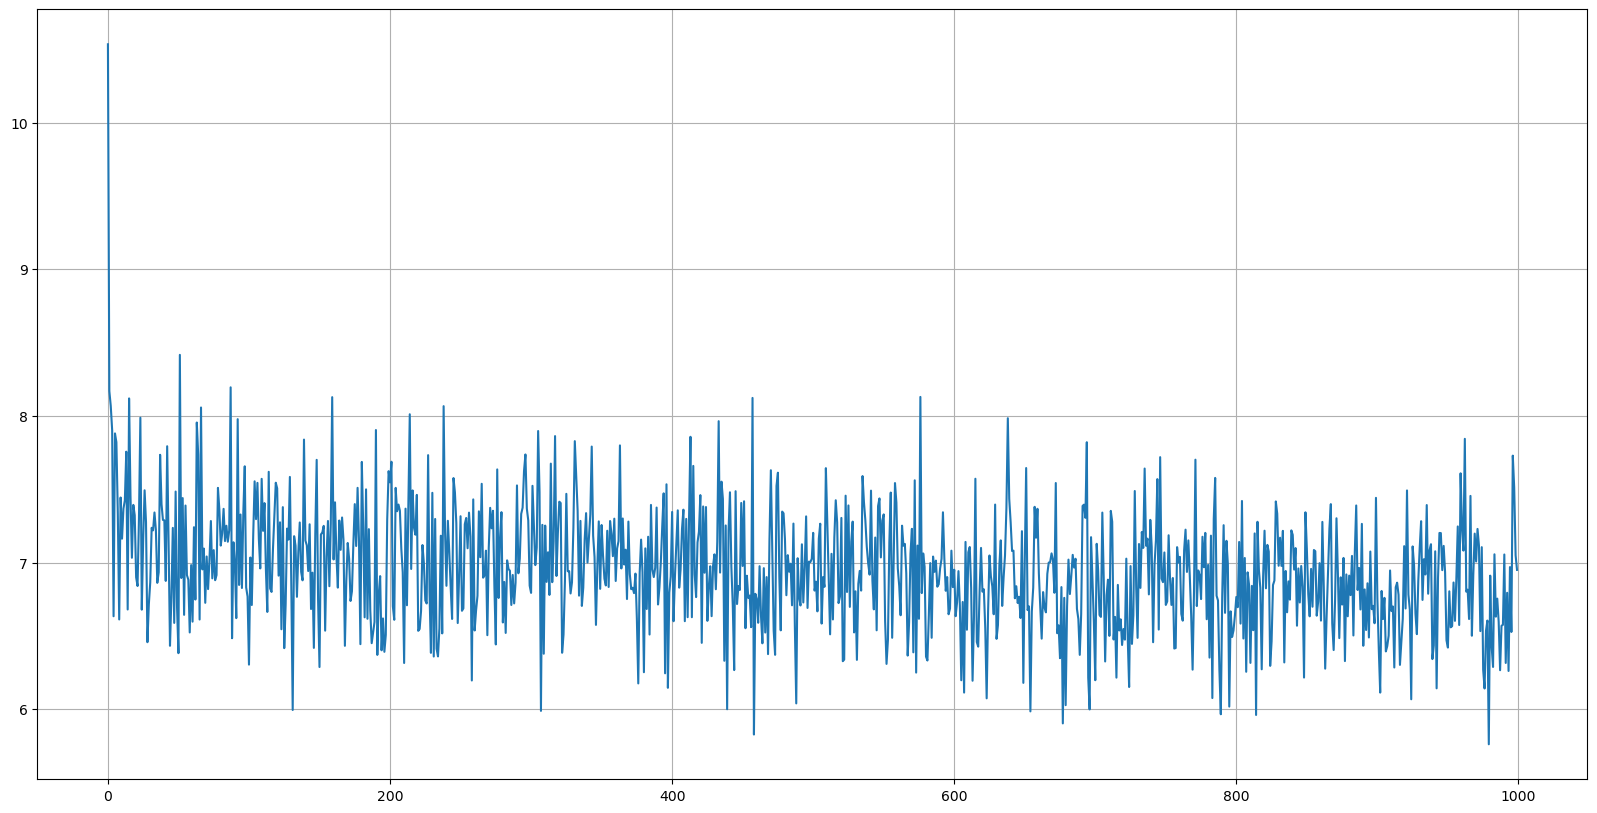

In [259]:
plt.figure(figsize=(20,10))
plt.grid('micro')
plt.plot(lossi);

In [260]:
-torch.tensor(1/num_words).log().mean()

tensor(9.6876)

In [261]:
output = []
sent = '<s> <s> <s>'
context = [wtoi[w] for w in sent.split()]

for _ in range(50):
    emb = C[torch.tensor([context])].view(1, -1)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    output.append(ix)

op = ' '.join(itow[i] for i in output)
print(op.replace('<s>', '\n'))

be me is singing in prithee I children the Dogs connive Forthwith tombs from brief Ere am the miracles maze I him constant advocate spies cabin: Lukes I citizens drink vaulty jewel too spell a they Thy sentence 
 your let flowerdeluce So live shows be: In me us I
